# DIVVY'IN UP DATA

## Overview

This project analyzes anonymized data from Divvy, a rideshare biking service in Chicago, IL. We chose to examine data in the third quarter of 2019 which includes the summer months and high volume of riders compared to other quarters. 

We wanted to uncover interesting patterns in the data. **We asked ourselves:**
* Are there routes and stations that are more popular than others?
* Are there any specific bikes that were rented a surprising amount?
* Are there any relationships between the age and/or gender when comparing one-time customers or yearly subscribers?
* How long, on average, are trips made by Divvy bike?

## Observations

**Popular Stations**
* The most popular station by far is Streeter Dr. and Grand Ave. which is located on Navy Pier. It is a popular destination for both tourists and locals. Indeed, this station appeared as either the starting or ending station on many of the most popular routes. 

**Popular Routes**
* All of the most frequented routes were in the loop and along the lakefront. Without knowing, we suspect that this is again a combination of tourists and commuters making use of the bikes in downtown Chicago. 

**Customers vs. Subscribers:** 
* There are far more subscribers than customers who ride in the Chicago Divvy network, about 84% to 16%
* This data may be skewed. We made an early call to drop any data with null values. We suspect that the dropped cells are more likely to be customers, one-time or infrequent users.

**Gender:**
* There are far more male Divvy riders than female - about 70% to 30%.
* It is fairly the same gender breakdown when it comes to customer (about 70/30) and subscriber (about 60/40).
* Divvy did not collect gender data beyond male and female, which means portions of Chicago's non-binary population are not accounted for in this dataset. 
    
**Age:**
* Riders aged 20-29 made up 47% of overall ridership with people aged 30-39 coming in second with 30% of overall ridership.
* The breakdown per usertype, customer versus subscriber, was similar to the overall categories. 

## Importing & Cleaning Data

In [1]:
# Import Dependencies
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import requests
import json
import os
import gmaps

# Import API key
from config import g_key

In [2]:
# Import data file
divvy_df = pd.read_csv('resources/Divvy_Trips_2019_Q3.csv')

In [3]:
# Remove null rows (if needed)
divvy_df.dropna()
divvy_df.shape

(1640718, 12)

In [4]:
# Display sample of dataframe
divvy_df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,23479388,2019-07-01 00:00:27,2019-07-01 00:20:41,3591,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0
1,23479389,2019-07-01 00:01:16,2019-07-01 00:18:44,5353,"1,048.0",381,Western Ave & Monroe St,203,Western Ave & 21st St,Customer,NaN,NaN
2,23479390,2019-07-01 00:01:48,2019-07-01 00:27:42,6180,"1,554.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN
3,23479391,2019-07-01 00:02:07,2019-07-01 00:27:10,5540,"1,503.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN
4,23479392,2019-07-01 00:02:13,2019-07-01 00:22:26,6014,"1,213.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN


In [5]:
# Find column names
divvy_df.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear'],
      dtype='object')

In [6]:
# Convert birthyear to age
divvy_df['age'] = (2019 - divvy_df['birthyear'])
divvy_df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
0,23479388,2019-07-01 00:00:27,2019-07-01 00:20:41,3591,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0,27.0
1,23479389,2019-07-01 00:01:16,2019-07-01 00:18:44,5353,"1,048.0",381,Western Ave & Monroe St,203,Western Ave & 21st St,Customer,NaN,NaN,NaN
2,23479390,2019-07-01 00:01:48,2019-07-01 00:27:42,6180,"1,554.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN
3,23479391,2019-07-01 00:02:07,2019-07-01 00:27:10,5540,"1,503.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN
4,23479392,2019-07-01 00:02:13,2019-07-01 00:22:26,6014,"1,213.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN,NaN


In [7]:
# Create bins for age
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Create the names for the five bins
group_names = ["11-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89"]
divvy_df["Age Group"] = pd.cut(divvy_df["age"], bins, labels=group_names, include_lowest=True)
divvy_df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,Age Group
0,23479388,2019-07-01 00:00:27,2019-07-01 00:20:41,3591,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0,27.0,20-29
1,23479389,2019-07-01 00:01:16,2019-07-01 00:18:44,5353,"1,048.0",381,Western Ave & Monroe St,203,Western Ave & 21st St,Customer,NaN,NaN,NaN,NaN
2,23479390,2019-07-01 00:01:48,2019-07-01 00:27:42,6180,"1,554.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN
3,23479391,2019-07-01 00:02:07,2019-07-01 00:27:10,5540,"1,503.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN
4,23479392,2019-07-01 00:02:13,2019-07-01 00:22:26,6014,"1,213.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN,NaN,NaN


In [8]:
divvy_df['time difference'] = ((pd.to_datetime(divvy_df['end_time']) - 
                            pd.to_datetime(divvy_df['start_time']))
                                .dt.total_seconds() / 60)
divvy_df

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,Age Group,time difference
0,23479388,2019-07-01 00:00:27,2019-07-01 00:20:41,3591,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0,27.0,20-29,20.233333
1,23479389,2019-07-01 00:01:16,2019-07-01 00:18:44,5353,"1,048.0",381,Western Ave & Monroe St,203,Western Ave & 21st St,Customer,NaN,NaN,NaN,NaN,17.466667
2,23479390,2019-07-01 00:01:48,2019-07-01 00:27:42,6180,"1,554.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN,25.900000
3,23479391,2019-07-01 00:02:07,2019-07-01 00:27:10,5540,"1,503.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN,25.050000
4,23479392,2019-07-01 00:02:13,2019-07-01 00:22:26,6014,"1,213.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN,NaN,NaN,20.216667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640713,25223635,2019-09-30 23:56:27,2019-10-01 00:06:20,5690,593.0,84,Milwaukee Ave & Grand Ave,134,Peoria St & Jackson Blvd,Subscriber,Male,1993.0,26.0,20-29,9.883333
1640714,25223636,2019-09-30 23:57:02,2019-10-01 00:02:13,5079,310.0,268,Lake Shore Dr & North Blvd,85,Michigan Ave & Oak St,Subscriber,Male,1992.0,27.0,20-29,5.183333
1640715,25223637,2019-09-30 23:57:45,2019-10-01 00:01:41,5535,235.0,423,University Ave & 57th St,426,Ellis Ave & 60th St,Customer,Male,2000.0,19.0,11-19,3.933333
1640716,25223638,2019-09-30 23:57:47,2019-10-01 00:04:41,6120,414.0,110,Dearborn St & Erie St,31,Franklin St & Chicago Ave (Temp),Subscriber,Male,1986.0,33.0,30-39,6.900000


In [9]:
# Convert date columns to datetime format
divvy_df['start_time'] = pd.to_datetime(divvy_df['start_time'])
divvy_df['end_time'] = pd.to_datetime(divvy_df['end_time'])

In [10]:
# Split date from time and create columns
divvy_df['start_date'] = divvy_df['start_time'].dt.date
divvy_df['start_time'] = divvy_df['start_time'].dt.time
divvy_df['end_date'] = divvy_df['end_time'].dt.date
divvy_df['end_time'] = divvy_df['end_time'].dt.time
divvy_df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,Age Group,time difference,start_date,end_date
0,23479388,00:00:27,00:20:41,3591,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0,27.0,20-29,20.233333,2019-07-01,2019-07-01
1,23479389,00:01:16,00:18:44,5353,"1,048.0",381,Western Ave & Monroe St,203,Western Ave & 21st St,Customer,NaN,NaN,NaN,NaN,17.466667,2019-07-01,2019-07-01
2,23479390,00:01:48,00:27:42,6180,"1,554.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN,25.900000,2019-07-01,2019-07-01
3,23479391,00:02:07,00:27:10,5540,"1,503.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN,25.050000,2019-07-01,2019-07-01
4,23479392,00:02:13,00:22:26,6014,"1,213.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN,NaN,NaN,20.216667,2019-07-01,2019-07-01


In [11]:
# Organize columns in dataframe
divvy_df = divvy_df[["trip_id", "bikeid", "start_date", "start_time", "time difference", "end_date", "end_time", "tripduration", "from_station_id", "from_station_name", "to_station_id", "to_station_name", "usertype", "gender", "birthyear", "age", "Age Group"]]
divvy_df.head(10)

,trip_id,bikeid,start_date,start_time,time difference,end_date,end_time,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,Age Group
0,23479388,3591,2019-07-01,00:00:27,20.233333,2019-07-01,00:20:41,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0,27.0,20-29
1,23479389,5353,2019-07-01,00:01:16,17.466667,2019-07-01,00:18:44,"1,048.0",381,Western Ave & Monroe St,203,Western Ave & 21st St,Customer,NaN,NaN,NaN,NaN
2,23479390,6180,2019-07-01,00:01:48,25.900000,2019-07-01,00:27:42,"1,554.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN
3,23479391,5540,2019-07-01,00:02:07,25.050000,2019-07-01,00:27:10,"1,503.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN
4,23479392,6014,2019-07-01,00:02:13,20.216667,2019-07-01,00:22:26,"1,213.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN,NaN,NaN
5,23479393,4941,2019-07-01,00:02:21,5.166667,2019-07-01,00:07:31,310.0,300,Broadway & Barry Ave,232,Pine Grove Ave & Waveland Ave,Subscriber,Male,1990.0,29.0,20-29
6,23479394,3770,2019-07-01,00:02:24,20.800000,2019-07-01,00:23:12,"1,248.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN,NaN,NaN
7,23479395,5442,2019-07-01,00:02:26,25.833333,2019-07-01,00:28:16,"1,550.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN
8,23479396,2957,2019-07-01,00:02:34,26.383333,2019-07-01,00:28:57,"1,583.0",43,Michigan Ave & Washington St,195,Columbus Dr & Randolph St,Customer,NaN,NaN,NaN,NaN
9,23479397,6091,2019-07-01,00:02:45,26.483333,2019-07-01,00:29:14,"1,589.0",43,Michigan Ave & Washington St,195,Columbus Dr & Randolph St,Customer,NaN,NaN,NaN,NaN


## Analysis

### Bike Usage

**Exploring the Data**

In [12]:
# Number of unique bikes in circulation
divvy_df['bikeid'].nunique()

5787

In [13]:
# Bike IDs with most activity
divvy_df['bikeid'].value_counts()

5724    535
3115    532
5344    531
3088    528
717     521
       ... 
1827      1
1806      1
3089      1
2705      1
3299      1
Name: bikeid, Length: 5787, dtype: int64

In [14]:
# Identify min / max duration of rides
max_duration = divvy_df['time difference'].max()
min_duration = divvy_df['time difference'].min()
mean = divvy_df['time difference'].mean()
median = divvy_df['time difference'].median()
mode = divvy_df['time difference'].mode()

# Print Summary Trip Duration Stats
print(f'Summary Trip Duration Statistics')
print(f'Max: {max_duration}')
print(f'Min: {min_duration}')
print(f'Mean: {mean}')
print(f'Median: {median}')
print(f'Mode: {mode}')

Summary Trip Duration Statistics
Max: 150943.9
Min: 1.0166666666666668
Mean: 29.036642575588115
Median: 13.55
Mode: 0    5.716667
dtype: float64


**Trip Duration**

The next few charts explore the trip duration of bikes. In the first scatterplot and boxplot, it's clear that most of the data is clustered to the left with some significant outliers. The next two charts reduce the data to rides under or equal to 100 minutes, showing how dense the datapoints are in the left section of the first two charts. These visualization help us determine that the median is the most useful number for getting a summary of most of the data. 

**Summary Statistics**
* Mean - 29.03 minutes
* Median - 13.55 minutes
* Mode - 5.72 minutes

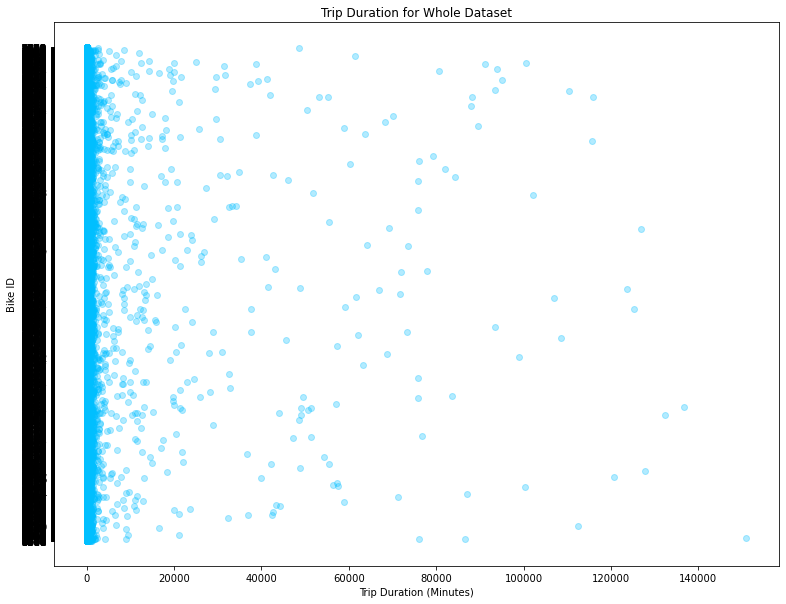

In [91]:
# Plot Trip Duration for Whole Dataset
plt.figure(figsize=(13,10))
Trip_Duration_All_data = plt.scatter(divvy_df['time difference'], divvy_df['bikeid'], color="deepskyblue", alpha = .3, edgecolors='deepskyblue')
plt.title("Trip Duration for Whole Dataset")
plt.xlabel("Trip Duration (Minutes)")
plt.ylabel("Bike ID")
plt.savefig('Images/Trip_Duration_Scatter_All.png')
plt.show()

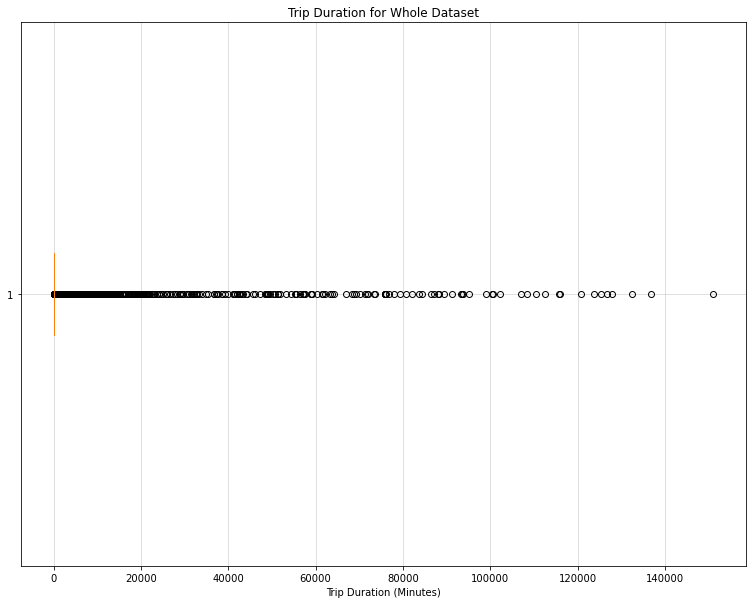

In [90]:
# Plot Trip Duration Data Points
plt.figure(figsize=(13,10))
plt.boxplot(divvy_df['time difference'], vert=False)
plt.title("Trip Duration for Whole Dataset")
plt.xlabel("Trip Duration (Minutes)")
plt.grid(True, alpha=.5)
plt.savefig('Images/Trip_Duration_Box_All.png')
plt.show()

In [24]:
# Reduce dataset to only rides less than or equal to 100 minutes
abridged_duration = divvy_df.loc[divvy_df['time difference']<=100]
abridged_duration

,trip_id,bikeid,start_date,start_time,time difference,end_date,end_time,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,Age Group
0,23479388,3591,2019-07-01,00:00:27,20.233333,2019-07-01,00:20:41,"1,214.0",117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,Subscriber,Male,1992.0,27.0,20-29
1,23479389,5353,2019-07-01,00:01:16,17.466667,2019-07-01,00:18:44,"1,048.0",381,Western Ave & Monroe St,203,Western Ave & 21st St,Customer,NaN,NaN,NaN,NaN
2,23479390,6180,2019-07-01,00:01:48,25.900000,2019-07-01,00:27:42,"1,554.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN
3,23479391,5540,2019-07-01,00:02:07,25.050000,2019-07-01,00:27:10,"1,503.0",313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,Customer,NaN,NaN,NaN,NaN
4,23479392,6014,2019-07-01,00:02:13,20.216667,2019-07-01,00:22:26,"1,213.0",168,Michigan Ave & 14th St,62,McCormick Place,Customer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640713,25223635,5690,2019-09-30,23:56:27,9.883333,2019-10-01,00:06:20,593.0,84,Milwaukee Ave & Grand Ave,134,Peoria St & Jackson Blvd,Subscriber,Male,1993.0,26.0,20-29
1640714,25223636,5079,2019-09-30,23:57:02,5.183333,2019-10-01,00:02:13,310.0,268,Lake Shore Dr & North Blvd,85,Michigan Ave & Oak St,Subscriber,Male,1992.0,27.0,20-29
1640715,25223637,5535,2019-09-30,23:57:45,3.933333,2019-10-01,00:01:41,235.0,423,University Ave & 57th St,426,Ellis Ave & 60th St,Customer,Male,2000.0,19.0,11-19
1640716,25223638,6120,2019-09-30,23:57:47,6.900000,2019-10-01,00:04:41,414.0,110,Dearborn St & Erie St,31,Franklin St & Chicago Ave (Temp),Subscriber,Male,1986.0,33.0,30-39


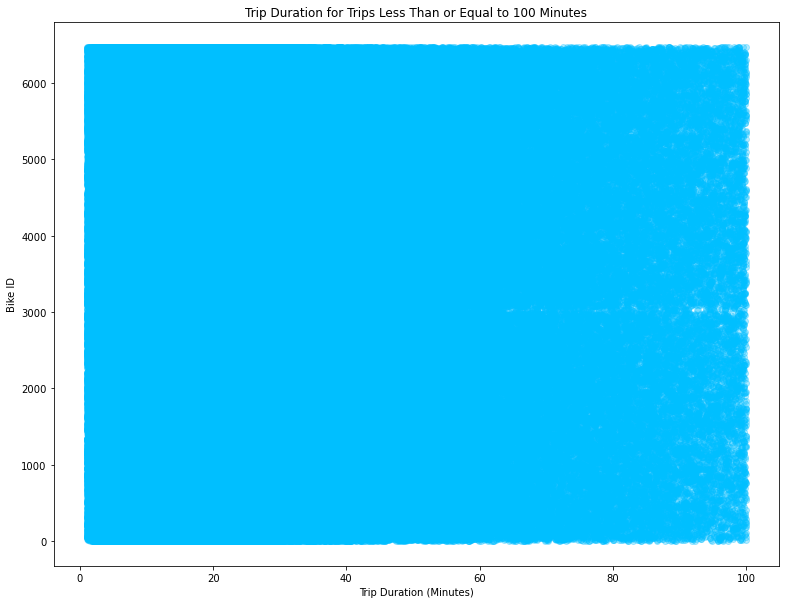

In [89]:
# Plot Trip Duration by Bike ID
plt.figure(figsize=(13,10))
plt.scatter(abridged_duration['time difference'], abridged_duration['bikeid'], color="deepskyblue", alpha = .3, edgecolors='deepskyblue')
plt.title("Trip Duration for Trips Less Than or Equal to 100 Minutes")
plt.xlabel("Trip Duration (Minutes)")
plt.ylabel("Bike ID")
plt.savefig('Images/Trip_Duration_Scatter_Under_100.png')
plt.show()

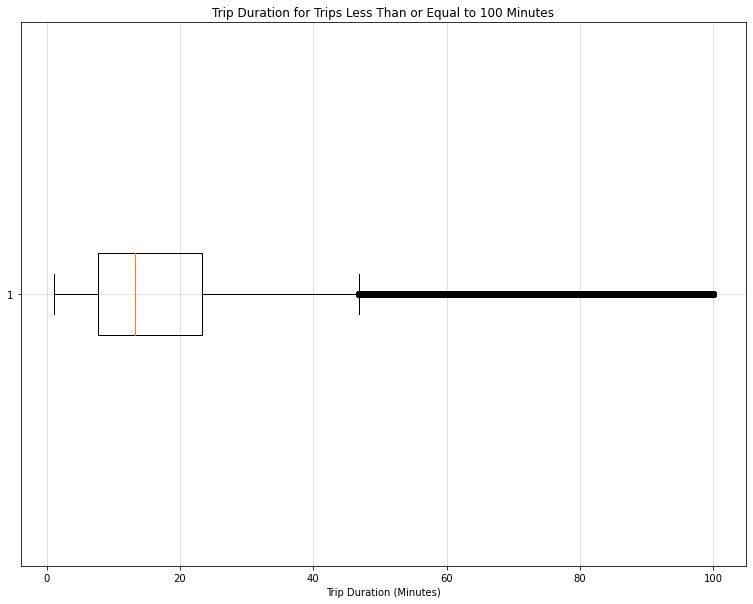

In [88]:
plt.figure(figsize=(13,10))
plt.boxplot(abridged_duration['time difference'], vert=False)
plt.title("Trip Duration for Trips Less Than or Equal to 100 Minutes")
plt.xlabel("Trip Duration (Minutes)")
plt.grid(True, alpha=.5)
plt.savefig('Images/Trip_Duration_Box_Under_100.png')
plt.show()

In [27]:
#TTEST
def gendata(loc=0):
    duration_sample = abridged_duration['time difference']
    duration_all = divvy_df['time difference']
    
    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(duration_all)), duration_all, label="trip duration")
    plt.scatter(range(len(duration_sample)), duration_sample, label="sample duration")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(duration_all, 20, density=True, alpha=0.7, label="trip duration")
    plt.hist(duration_sample, 20, density=True, alpha=0.7, label="sample duration")
    plt.axvline(duration_all.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(duration_sample.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return duration_all, duration_sample

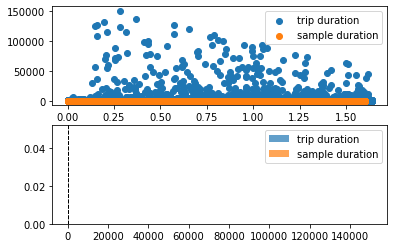

In [87]:
duration_all, duration_sample = gendata()
plt.savefig('Images/TTest.png')

In [30]:
stats.ttest_1samp(duration_sample, duration_all.mean())

Ttest_1sampResult(statistic=-874.803596673298, pvalue=0.0)

In [31]:
popular_bikes = divvy_df['bikeid'].value_counts().head(20)
popular_bikes

5724    535
3115    532
5344    531
3088    528
717     521
5634    520
6079    519
4638    518
320     517
3770    516
6425    515
6198    514
4877    513
522     509
749     507
5501    506
3333    506
682     505
4781    505
4020    505
Name: bikeid, dtype: int64

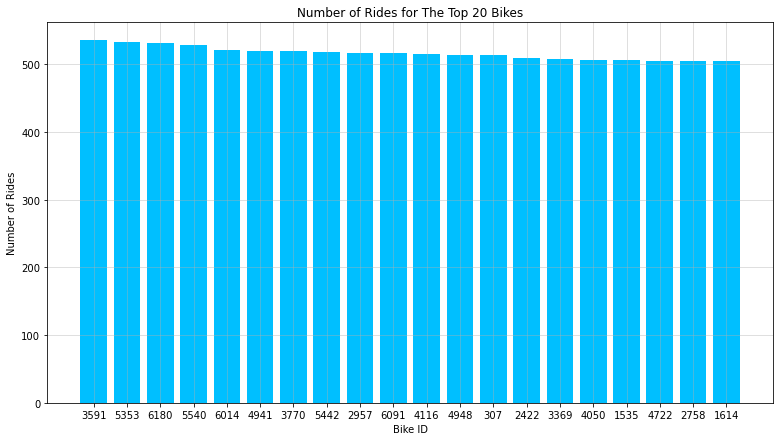

In [86]:
# Rides for top 20 bikes
divvy_df['bikeid'] = divvy_df['bikeid'].astype(str)
divvy_df['bikeid'].dtypes
plt.figure(figsize=(13,7))
plt.bar(divvy_df['bikeid'].head(20), popular_bikes, color='deepskyblue')
plt.title("Number of Rides for The Top 20 Bikes")
plt.xlabel("Bike ID")
plt.ylabel("Number of Rides")
plt.grid(True, alpha=.5)
plt.savefig('Images/Rides_per_Top_20_Bikes.png')

In [34]:
# Find 20 most used bike IDs
popular_bikes = divvy_df['bikeid'].value_counts().head(20)
popular_bikes

5724    535
3115    532
5344    531
3088    528
717     521
5634    520
6079    519
4638    518
320     517
3770    516
6425    515
6198    514
4877    513
522     509
749     507
3333    506
5501    506
682     505
4781    505
4020    505
Name: bikeid, dtype: int64

In [35]:
# Convert bike ID to string
divvy_df['bikeid'] = divvy_df['bikeid'].astype(str)
divvy_df['bikeid'].dtypes

dtype('O')

### Popular Stations

In [36]:
# Identify the most popular starting stations
top_routes = divvy_df['from_station_name'].value_counts()
total_trips_df = pd.DataFrame({
    'total trips': top_routes
})

# Reduce the results to any stations with trip greater than or equal to 10,000
total_trips_reduced = total_trips_df.loc[total_trips_df['total trips'] >= 10000]
total_trips_reduced

,total trips
Streeter Dr & Grand Ave,39726
Lake Shore Dr & Monroe St,26309
Lake Shore Dr & North Blvd,21845
Michigan Ave & Oak St,20300
Canal St & Adams St,20176
Clinton St & Madison St,19019
Theater on the Lake,18491
Millennium Park,18337
Clinton St & Washington Blvd,16854
Michigan Ave & Washington St,16073


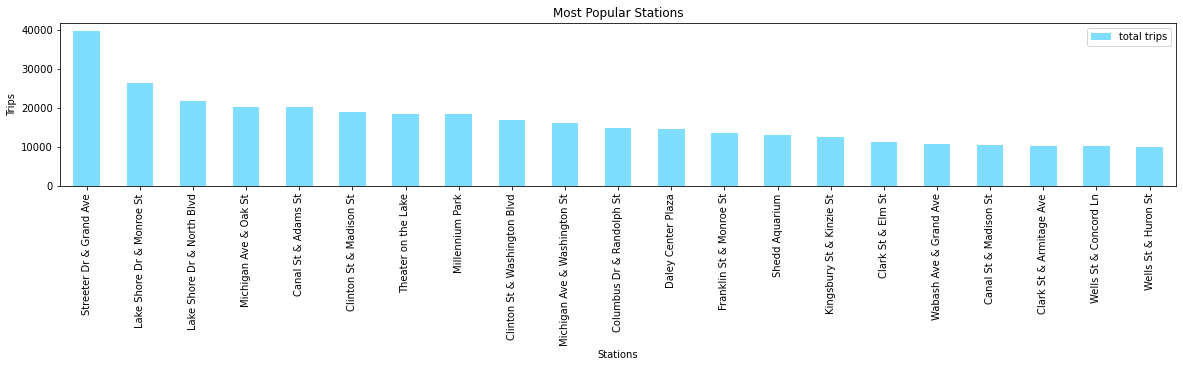

<Figure size 432x288 with 0 Axes>

In [85]:
# Display a bar chart of the 25 most popular stations
total_trips_reduced.plot(kind='bar', color='deepskyblue', alpha=.5, align='center', figsize=(20,3))
plt.title('Most Popular Stations')
plt.xlabel('Stations')
plt.ylabel('Trips')
plt.savefig('Images/Most_Popular_Stations.png')
plt.show()
plt.tight_layout()

### Popular Routes

In [40]:
# Create a dataframe shows the most popular ending station for popular starting stations
divvy_rides = {'from_station': divvy_df['from_station_name'],
               'to_station': divvy_df['to_station_name']
              }

divvy_rides_df = pd.DataFrame(divvy_rides, columns=['from_station', 'to_station'])
dup_to_from = divvy_rides_df.pivot_table(index=['from_station', 'to_station'], aggfunc='size')

# Reconfigure dataframe to display data side by side
dup_to_from.columns = dup_to_from.droplevel(0)
dup_to_from.columns.name = None
dup_to_from_II = dup_to_from.reset_index()

# Rename dataframe columns
to_from_III = dup_to_from_II.rename(columns={'from_station': 'from_station', 'to_station':'to_station', 0:'rides_taken'})
to_from_III

,from_station,to_station,rides_taken
0,2112 W Peterson Ave,2112 W Peterson Ave,6
1,2112 W Peterson Ave,Broadway & Argyle St,2
2,2112 W Peterson Ave,Broadway & Barry Ave,2
3,2112 W Peterson Ave,Broadway & Berwyn Ave,3
4,2112 W Peterson Ave,Broadway & Granville Ave,6
...,...,...,...
101526,Yates Blvd & 75th St,South Shore Dr & 71st St,4
101527,Yates Blvd & 75th St,South Shore Dr & 74th St,3
101528,Yates Blvd & 75th St,Stony Island Ave & 82nd St,1
101529,Yates Blvd & 75th St,Woodlawn Ave & Lake Park Ave,1


In [41]:
# Remove rows where start and end station were identical
to_from_removed_dups = to_from_III[to_from_III['from_station'] != to_from_III['to_station']]

# Sort dataframe of start/end stations, sort, and identify 25 most popular routes
most_pop_rides = to_from_removed_dups.loc[to_from_removed_dups.groupby('from_station')['rides_taken'].idxmax()]
most_popular_routes = most_pop_rides.sort_values(ascending=False, by='rides_taken').reset_index(drop=True)
most_popular_reduced = most_popular_routes[0:25]
most_popular_reduced

,from_station,to_station,rides_taken
0,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,5055
1,Streeter Dr & Grand Ave,Lake Shore Dr & North Blvd,2132
2,Shedd Aquarium,Streeter Dr & Grand Ave,1813
3,Millennium Park,Streeter Dr & Grand Ave,1775
4,Lake Shore Dr & North Blvd,Streeter Dr & Grand Ave,1703
5,Theater on the Lake,Streeter Dr & Grand Ave,1559
6,Dusable Harbor,Streeter Dr & Grand Ave,1414
7,Canal St & Adams St,Michigan Ave & Washington St,1355
8,Michigan Ave & Oak St,Streeter Dr & Grand Ave,1334
9,Michigan Ave & Washington St,Clinton St & Washington Blvd,1056


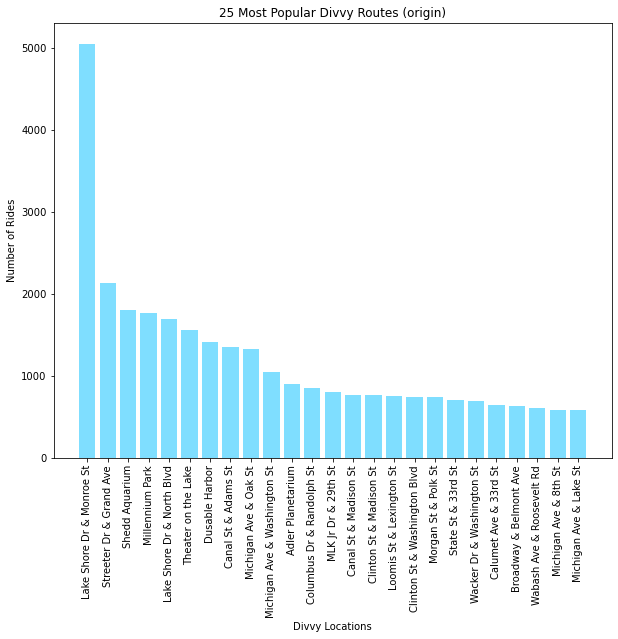

<Figure size 432x288 with 0 Axes>

In [84]:
# Create a bar chart of the 25 most popular routes
plt.figure(figsize=(10,8))
plt.bar(most_popular_reduced['from_station'], most_popular_reduced['rides_taken'], color='deepskyblue', alpha=.5, align='center')
plt.xticks(most_popular_reduced['from_station'], rotation='vertical')
plt.title('25 Most Popular Divvy Routes (origin)')
plt.xlabel('Divvy Locations')
plt.ylabel('Number of Rides')
plt.savefig('Images/Most Popular Routes.png')
plt.show()
plt.tight_layout()

In [43]:
mpr = most_popular_reduced.copy()

In [44]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
mask = mpr['from_station'].str.startswith('L')
mpr.loc[mask, 'to_station'] = 'Streeter Dr & Grand Ave'
mpr

,from_station,to_station,rides_taken
0,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,5055
1,Streeter Dr & Grand Ave,Lake Shore Dr & North Blvd,2132
2,Shedd Aquarium,Streeter Dr & Grand Ave,1813
3,Millennium Park,Streeter Dr & Grand Ave,1775
4,Lake Shore Dr & North Blvd,Streeter Dr & Grand Ave,1703
5,Theater on the Lake,Streeter Dr & Grand Ave,1559
6,Dusable Harbor,Streeter Dr & Grand Ave,1414
7,Canal St & Adams St,Michigan Ave & Washington St,1355
8,Michigan Ave & Oak St,Streeter Dr & Grand Ave,1334
9,Michigan Ave & Washington St,Clinton St & Washington Blvd,1056


In [45]:
mpr_I = mpr["from_station"] = mpr["from_station"].str.replace(' ', '+')
mpr_I
mpr_I = mpr["from_station"] = mpr["from_station"].str.replace('&', 'and')
mpr_I = mpr["from_station"] = mpr["from_station"].str.lstrip()

mpr_I

0        Lake+Shore+Dr+and+Monroe+St
1          Streeter+Dr+and+Grand+Ave
2                     Shedd+Aquarium
3                    Millennium+Park
4       Lake+Shore+Dr+and+North+Blvd
5                Theater+on+the+Lake
6                     Dusable+Harbor
7              Canal+St+and+Adams+St
8            Michigan+Ave+and+Oak+St
9     Michigan+Ave+and+Washington+St
10                 Adler+Planetarium
11       Columbus+Dr+and+Randolph+St
12             MLK+Jr+Dr+and+29th+St
13           Canal+St+and+Madison+St
14         Clinton+St+and+Madison+St
15        Loomis+St+and+Lexington+St
16    Clinton+St+and+Washington+Blvd
17             Morgan+St+and+Polk+St
18              State+St+and+33rd+St
19       Wacker+Dr+and+Washington+St
20           Calumet+Ave+and+33rd+St
21          Broadway+and+Belmont+Ave
22       Wabash+Ave+and+Roosevelt+Rd
23           Michigan+Ave+and+8th+St
24          Michigan+Ave+and+Lake+St
Name: from_station, dtype: object

In [46]:
# stations = mpr_I["from_station"]   
place_id = []
latitude = []
longitude = []

for station in mpr_I:
    url = "https://maps.googleapis.com/maps/api/geocode/json?"
    address = 'address=' + station
    api_key = '&key=' + g_key
    city_state = ',+Chicago,+IL"'
    
    
    response = requests.get(url +  address + city_state + api_key).json()
    print(json.dumps(response, indent=4, sort_keys=True))
    
    place_id.append(response['results'][0]["place_id"])
    latitude.append(response['results'][0]['geometry']['location']['lat'])
    longitude.append(response['results'][0]['geometry']['location']['lng'])

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "South Lake Shore Drive & East Monroe Street",
                    "short_name": "S Lake Shore Dr & E Monroe St",
                    "types": [
                        "intersection"
                    ]
                },
                {
                    "long_name": "Chicago Loop",
                    "short_name": "Chicago Loop",
                    "types": [
                        "neighborhood",
                        "political"
                    ]
                },
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                    "types":

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "Millennium Park",
                    "short_name": "Millennium Park",
                    "types": [
                        "neighborhood",
                        "political"
                    ]
                },
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                    "types": [
                        "administrative_area_level_2",
                        "political"
                    ]
                },
                {
                    "long_name": "Illinois",
                    "short_name": "IL",
                    "types": [
 

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "South Canal Street & West Adams Street",
                    "short_name": "S Canal St & W Adams St",
                    "types": [
                        "intersection"
                    ]
                },
                {
                    "long_name": "West Loop",
                    "short_name": "West Loop",
                    "types": [
                        "neighborhood",
                        "political"
                    ]
                },
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                    "types": [
              

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "1300",
                    "short_name": "1300",
                    "types": [
                        "street_number"
                    ]
                },
                {
                    "long_name": "South Lake Shore Drive",
                    "short_name": "S Lake Shore Dr",
                    "types": [
                        "route"
                    ]
                },
                {
                    "long_name": "Near South Side",
                    "short_name": "Near South Side",
                    "types": [
                        "neighborhood",
                        "political"
                    ]
                },
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
       

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "South Canal Street & West Madison Street",
                    "short_name": "S Canal St & W Madison St",
                    "types": [
                        "intersection"
                    ]
                },
                {
                    "long_name": "West Loop",
                    "short_name": "West Loop",
                    "types": [
                        "neighborhood",
                        "political"
                    ]
                },
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                    "types": [
          

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "West Washington Boulevard & North Clinton Street",
                    "short_name": "W Washington Blvd & N Clinton St",
                    "types": [
                        "intersection"
                    ]
                },
                {
                    "long_name": "West Loop",
                    "short_name": "West Loop",
                    "types": [
                        "neighborhood",
                        "political"
                    ]
                },
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                    "types

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "West Washington Street & North Upper Wacker Drive",
                    "short_name": "W Washington St & N Upper Wacker Dr",
                    "types": [
                        "intersection"
                    ]
                },
                {
                    "long_name": "Chicago Loop",
                    "short_name": "Chicago Loop",
                    "types": [
                        "neighborhood",
                        "political"
                    ]
                },
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                

{
    "results": [
        {
            "address_components": [
                {
                    "long_name": "Roosevelt Road & South Wabash Avenue",
                    "short_name": "Roosevelt Rd & S Wabash Ave",
                    "types": [
                        "intersection"
                    ]
                },
                {
                    "long_name": "Near South Side",
                    "short_name": "Near South Side",
                    "types": [
                        "neighborhood",
                        "political"
                    ]
                },
                {
                    "long_name": "Chicago",
                    "short_name": "Chicago",
                    "types": [
                        "locality",
                        "political"
                    ]
                },
                {
                    "long_name": "Cook County",
                    "short_name": "Cook County",
                    "types": [


In [47]:
mpr["Place ID"] = place_id
mpr["latitude"] = latitude
mpr["longitude"] = longitude
mpr

,from_station,to_station,rides_taken,Place ID,latitude,longitude
0,Lake+Shore+Dr+and+Monroe+St,Streeter Dr & Grand Ave,5055,EjVTIExha2UgU2hvcmUgRHIgJiBFIE1vbnJvZSBTdCwgQ2...,41.880936,-87.617496
1,Streeter+Dr+and+Grand+Ave,Lake Shore Dr & North Blvd,2132,EjNFIEdyYW5kIEF2ZSAmIE4gU3RyZWV0ZXIgRHIsIENoaW...,41.892123,-87.610043
2,Shedd+Aquarium,Streeter Dr & Grand Ave,1813,ChIJ-XW3X2MrDogR3_tQ3-OdBTI,41.867573,-87.614038
3,Millennium+Park,Streeter Dr & Grand Ave,1775,ChIJgfAAC6csDogRK6Ew7nIj9ss,41.882702,-87.619394
4,Lake+Shore+Dr+and+North+Blvd,Streeter Dr & Grand Ave,1703,EiFOIExha2UgU2hvcmUgRHIsIENoaWNhZ28sIElMLCBVU0...,41.934512,-87.632403
5,Theater+on+the+Lake,Streeter Dr & Grand Ave,1559,ChIJ9wm2tXHTD4gRaSxHG55KHFQ,41.927075,-87.630666
6,Dusable+Harbor,Streeter Dr & Grand Ave,1414,ChIJUe7Hi1ArDogRkwk1xuXospA,41.885597,-87.611850
7,Canal+St+and+Adams+St,Michigan Ave & Washington St,1355,Ei9TIENhbmFsIFN0ICYgVyBBZGFtcyBTdCwgQ2hpY2Fnby...,41.879304,-87.639607
8,Michigan+Ave+and+Oak+St,Streeter Dr & Grand Ave,1334,Ei9NaWNoaWdhbiBBdmUgJiBFIE9hayBTdCwgQ2hpY2Fnby...,41.900798,-87.624239
9,Michigan+Ave+and+Washington+St,Clinton St & Washington Blvd,1056,EjZNaWNoaWdhbiBBdmUgJiBFIFdhc2hpbmd0b24gU3QsIE...,41.883235,-87.624244


In [48]:
gmaps.configure(api_key=g_key)

locations = mpr[["latitude", "longitude"]].astype(float)
rides = mpr['rides_taken'].astype(int)

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=rides, max_intensity=100,
                                 point_radius = 10)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

### Comparing Subscribers & Customers

There are far more subscribers than customers who ride in the Chicago Divvy network, about 84% to 16%. It's important to note that this data may be skewed. We made an early call to drop any data with null values. We suspect that the dropped cells are more likely to be customers, one-time or infrequent users who are less likely to fill out their full profile on the app. This caveat applies to subsequent analysis on age and gender. 

In [49]:
# Groupby usertype for ridership breakdown
usertype_df = divvy_df.groupby('usertype')
usertype_df.count()

,trip_id,bikeid,start_date,start_time,time difference,end_date,end_time,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,gender,birthyear,age,Age Group
usertype,,,,,,,,,,,,,,,,
Customer,491694,491694,491694,491694,491694,491694,491694,491694,491694,491694,491694,491694,214116,216619,216619,216591
Subscriber,1149024,1149024,1149024,1149024,1149024,1149024,1149024,1149024,1149024,1149024,1149024,1149024,1139252,1146005,1146005,1145657


In [50]:
# Find amount ot Subscribers and Customers
divvy_df['usertype'].value_counts()

Subscriber    1149024
Customer       491694
Name: usertype, dtype: int64

In [51]:
# Find Usertype Percentage

# Count number of trips for each usertype
count_number_usertype = divvy_df['trip_id'].nunique()

# Count number of each usertype
usertype_number = usertype_df['trip_id'].nunique()

# Percentage Usertype Calculation
percent_usertype =  round((usertype_number / count_number_usertype * 100),)

# Display usertype demographics
usertype_demographics_df = pd.DataFrame({'Total Count':usertype_number,
                                       'Percentage':percent_usertype})
usertype_demographics_df.sort_values('Total Count', ascending = False)

,Total Count,Percentage
usertype,,
Subscriber,1149024,70.0
Customer,491694,30.0


### Use by Gender

For all customers the data shows that there are far more male Divvy riders than female - about 70% to 30%. If you just look at customers, that breakdown remains consistent. Subscribers are slightly more balanced between genders with 60% male rides and 40% female riders.

Here again, we need to examine the data available. There are two factors to consider. The first, we've already discussed. Our choice to remove any cells with null values. We wanted to check where those null values were in our data and discovered that 287,350 cells with null-gender data were dropped (see below). 

In [52]:
# Examine count of non-null values
divvy_df.dtypes
divvy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640718 entries, 0 to 1640717
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   trip_id            1640718 non-null  int64   
 1   bikeid             1640718 non-null  object  
 2   start_date         1640718 non-null  object  
 3   start_time         1640718 non-null  object  
 4   time difference    1640718 non-null  float64 
 5   end_date           1640718 non-null  object  
 6   end_time           1640718 non-null  object  
 7   tripduration       1640718 non-null  object  
 8   from_station_id    1640718 non-null  int64   
 9   from_station_name  1640718 non-null  object  
 10  to_station_id      1640718 non-null  int64   
 11  to_station_name    1640718 non-null  object  
 12  usertype           1640718 non-null  object  
 13  gender             1353368 non-null  object  
 14  birthyear          1362624 non-null  float64 
 15  age            

We also noticed that Divvy only collected data for two genders, male and female, not allowing for any other gender identities across the spectrum. In a city like Chicago, with a significant LGBTQ population, this makes for inaccurate data on gender. Our speculation is that some of the dropped rides included riders who didn't select male or female because those labels did not describe them. 

In [53]:
# Find amount of Male and Female riders
divvy_df['gender'].value_counts()

Male      957353
Female    396015
Name: gender, dtype: int64

In [54]:
# Group by gender
usertype_gender_df = divvy_df.groupby('gender')

# Count number of trips for each gender
count_number_gender = divvy_df['trip_id'].nunique()

# Count number of each gender
gender_type_number = usertype_gender_df['trip_id'].nunique()

# Calculate percentage for gender
percent_gender =  round((gender_type_number / count_number_gender * 100),2)

# Display gender demographics
gender_demographics_df = pd.DataFrame({'Total Count':gender_type_number,
                                       'Percentage':percent_gender})
gender_demographics_df.sort_values('Total Count', ascending = False)

,Total Count,Percentage
gender,,
Male,957353,58.35
Female,396015,24.14


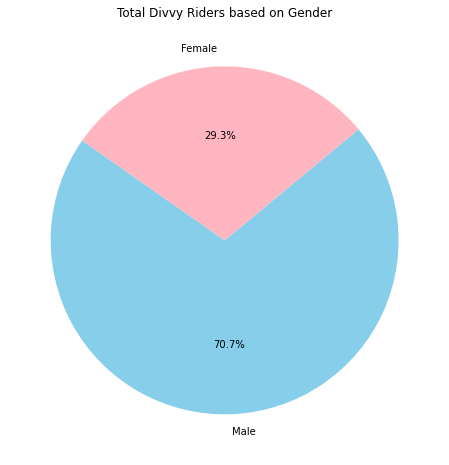

In [83]:
# Total Divvy Riders based on Gender- PIE CHART
gender_data = divvy_df['gender'].value_counts()
gender_labels = ['Male','Female']
colours = ['skyblue', 'lightpink']
plt.figure(figsize=(10,8))
plt.pie(gender_data, labels= gender_labels, colors=colours, autopct="%1.1f%%", startangle=145)
plt.title("Total Divvy Riders based on Gender")
plt.savefig('Images/Gender_Overall.png')

In [57]:
# Find breakdown of each gender for each usertype
usertype_gender_df['usertype'].value_counts()

gender  usertype  
Female  Subscriber    313303
        Customer       82712
Male    Subscriber    825949
        Customer      131404
Name: usertype, dtype: int64

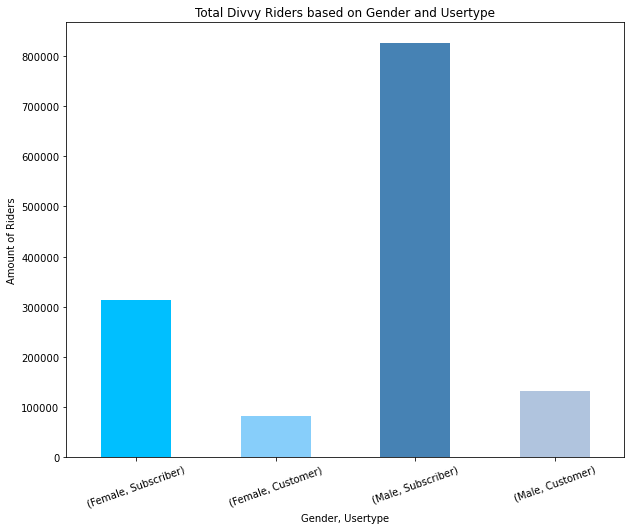

In [82]:
# Total Divvy Riders based on Gender and Usertype- Bar Graph
split_gender_data = usertype_gender_df['usertype'].value_counts()
blue_colors = ["deepskyblue", "lightskyblue", "steelblue", "lightsteelblue"]
plt.figure(figsize=(10,8))
gender_chart = split_gender_data.plot(kind = 'bar', color = blue_colors, rot = 20)
gender_chart.set_ylabel("Amount of Riders")
gender_chart.set_xlabel("Gender, Usertype")
gender_chart.set_title("Total Divvy Riders based on Gender and Usertype")
plt.savefig('Images/Gender_Customers_Only.png')

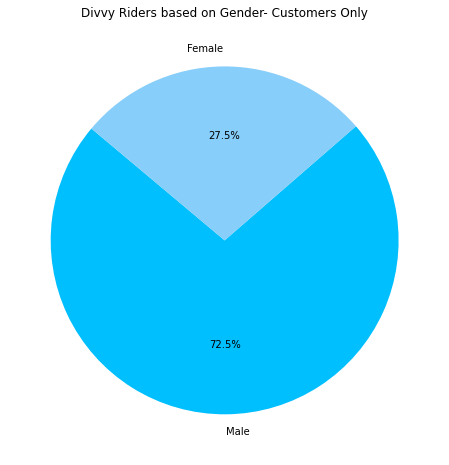

In [81]:
# Divvy Riders based on Gender- Customers Only
sizes = [825949,313303]
skyblue_colors = ["deepskyblue", "lightskyblue"]
plt.figure(figsize=(10,8))
plt.pie(sizes, labels= gender_labels, colors=skyblue_colors, autopct="%1.1f%%", startangle=140)
plt.title("Divvy Riders based on Gender- Customers Only")
plt.savefig('Images/Gender_Customers_and_Subscribers.png')

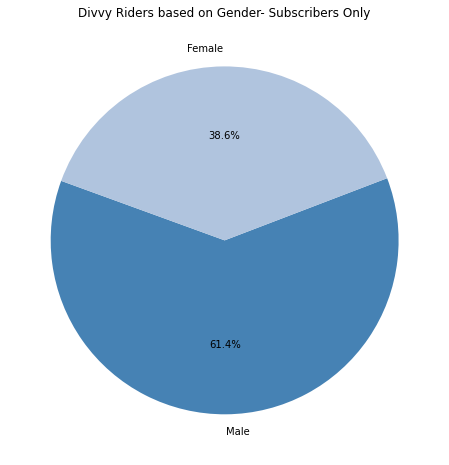

In [79]:
# Divvy Riders based on Gender- Subscribers Only
sizes = [131404,82712]
steel_colors = ["steelblue", "lightsteelblue"]
plt.figure(figsize=(10,8))
plt.pie(sizes, labels= gender_labels, colors=steel_colors, autopct="%1.1f%%", startangle=160)
plt.title("Divvy Riders based on Gender- Subscribers Only")
plt.savefig('Images/Genders_Subscribers_Only.png')

### Use by Age Group

In [62]:
# Count number of trips for each age group
count_number_age = divvy_df['trip_id'].nunique()

# Count number in each age group and display
usertype_age_df = divvy_df.groupby('Age Group')
age_type_number = usertype_age_df['trip_id'].nunique()
usertype_age_df.count()

,trip_id,bikeid,start_date,start_time,time difference,end_date,end_time,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
Age Group,,,,,,,,,,,,,,,,
11-19,24439,24439,24439,24439,24439,24439,24439,24439,24439,24439,24439,24439,24439,24148,24439,24439
20-29,637735,637735,637735,637735,637735,637735,637735,637735,637735,637735,637735,637735,637735,633811,637735,637735
30-39,405750,405750,405750,405750,405750,405750,405750,405750,405750,405750,405750,405750,405750,402889,405750,405750
40-49,152741,152741,152741,152741,152741,152741,152741,152741,152741,152741,152741,152741,152741,151754,152741,152741
50-59,107283,107283,107283,107283,107283,107283,107283,107283,107283,107283,107283,107283,107283,106465,107283,107283
60-69,31557,31557,31557,31557,31557,31557,31557,31557,31557,31557,31557,31557,31557,31272,31557,31557
70-79,2710,2710,2710,2710,2710,2710,2710,2710,2710,2710,2710,2710,2710,2656,2710,2710
80-89,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33


In [63]:
# Average Trip Duration
average_duration = usertype_age_df['tripduration'].count().mean()
average_duration

170281.0

In [64]:
# Calculate percentage for age
percent_age =  age_type_number / count_number_age * 100

# Make df of age demographics
age_demographics_df = pd.DataFrame({'Total Count':age_type_number,
                                       'Percentage of Age':percent_age})
age_demographics_df.sort_values('Age Group', ascending = True)

,Total Count,Percentage of Age
Age Group,,
11-19,24439,1.489531
20-29,637735,38.869263
30-39,405750,24.730027
40-49,152741,9.309400
50-59,107283,6.538784
60-69,31557,1.923365
70-79,2710,0.165172
80-89,33,0.002011


Text(0.5, 1.0, 'Percentage Divvy Riders Based on Age')

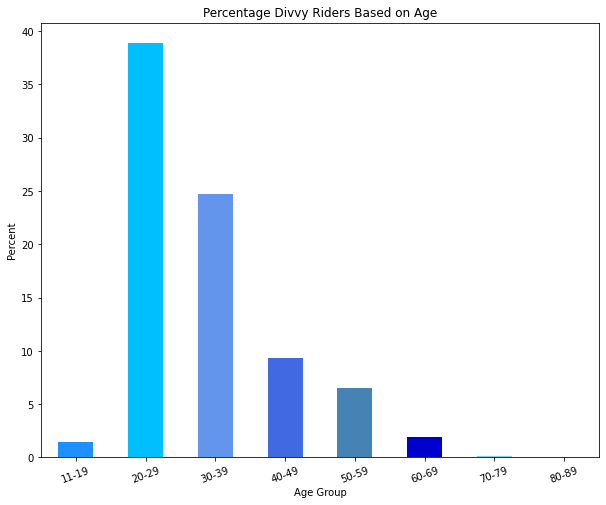

<Figure size 720x576 with 0 Axes>

In [78]:
# Percentage Divvy Riders based on Age- Bar Chart
plt.figure(figsize=(10,8))
percent_chart = percent_age.plot(kind = 'bar', color = rainbow_colors, rot = 20)
plt.savefig('Images/Age_Overall.png')
plt.figure(figsize=(10,8))
percent_chart.set_ylabel("Percent")
percent_chart.set_xlabel("Age Group")
percent_chart.set_title("Percentage Divvy Riders Based on Age")

In [68]:
# Age seperated by usertype
usertype_age_df['usertype'].value_counts()

Age Group  usertype  
11-19      Customer       12232
           Subscriber     12207
20-29      Subscriber    515465
           Customer      122270
30-39      Subscriber    357309
           Customer       48441
40-49      Subscriber    133147
           Customer       19594
50-59      Subscriber     95445
           Customer       11838
60-69      Subscriber     29468
           Customer        2089
70-79      Subscriber      2586
           Customer         124
80-89      Subscriber        30
           Customer           3
Name: usertype, dtype: int64

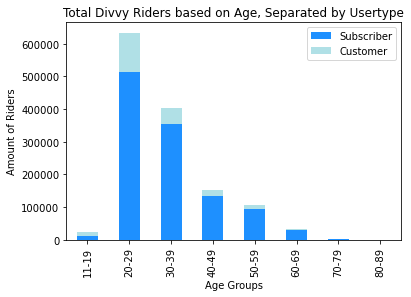

In [76]:
# Total Divvy Riders based on Age, Separated by Usertype- Stacked Histogram
subscriber_age_totals = [12093,512720,355281,132359,94713,29201,2535,30]
customer_age_totals = [12055,121091,47608,19395,11752,2071,121,3]
plotdata = pd.DataFrame({
    "Subscriber":subscriber_age_totals,
    "Customer":customer_age_totals
    }, 
    index= group_names
    )
plotdata[["Subscriber", "Customer"]].plot(kind="bar", color=['dodgerblue','powderblue'], stacked=True)
plt.title("Total Divvy Riders based on Age, Separated by Usertype")
plt.xlabel("Age Groups")
plt.ylabel("Amount of Riders")
plt.savefig('Images/Age_Customers_and_Subscribers.png')

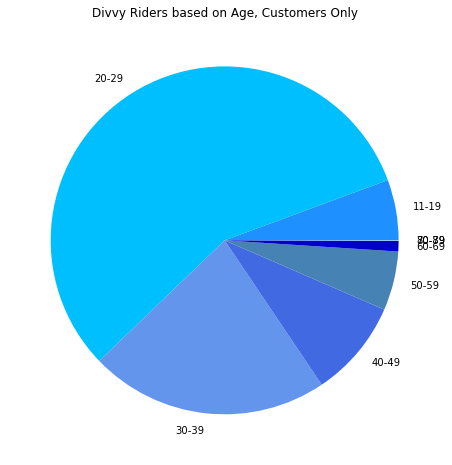

In [75]:
# Divvy Riders based on Age, Customers Only- PIE CHART
customer_age_totals = [12055,121091,47608,19395,11752,2071,121,3]
plt.figure(figsize=(10,8))
plt.pie(customer_age_totals, labels= group_names, colors=rainbow_colors)
#autopct="%1.1f%%"
#startangle=90
plt.title("Divvy Riders based on Age, Customers Only")
plt.savefig('Images/Age_Customers_Only.png')

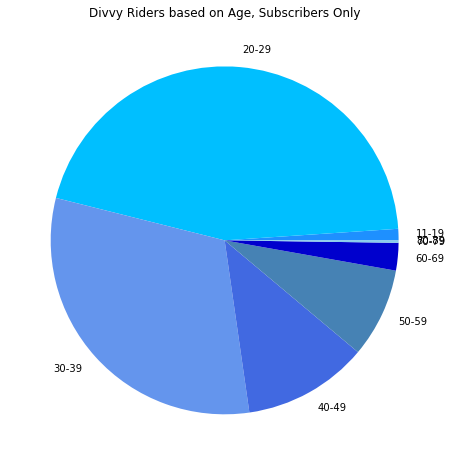

In [74]:
# Divvy Riders based on Age, Subscribers Only- PIE CHART
plt.figure(figsize=(10,8))
plt.pie(subscriber_age_totals, labels= group_names, colors = rainbow_colors)
#startangle=90
#autopct="%1.1f%%",
plt.title("Divvy Riders based on Age, Subscribers Only")
plt.savefig('Images/Age_Subscribers_Only.png')